In [20]:
import pandas as pd
import numpy as np 
from numpy import linspace,hstack


import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
from pylab import plot,show,hist, rcParams
rcParams['figure.figsize'] = 10, 6


from scipy.stats.kde import gaussian_kde

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

# Реализация

### Загрузка данных

In [2]:
df = pd.read_json('banki_responses.json', lines=True)

In [3]:
df.shape

(201030, 10)

In [4]:
df.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,e.novikova,лицензия № 1623,ВТБ 24,г. Воронеж,2015-06-08 11:06:56,0,5.0,True,Здравствуйте! Хотелось бы выразить благодарно...,Ипотека на 5+
1,KZN\Vorontsova_NA,лицензия № 2289,Русский Стандарт,г. Казань,2015-06-06 18:17:52,0,2.0,True,Уважаемые представители департамента по работе...,ЗВОНКИ СОСЕДЯМ
2,Evgenia15,лицензия № 2307,Союз,г. Санкт-Петербург,2015-06-07 19:08:33,0,2.0,True,Здравствуйте. Столкнулась с такой ситуацией. в...,Ложная информация!!!!


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201030 entries, 0 to 201029
Data columns (total 10 columns):
author                201009 non-null object
bank_license          201026 non-null object
bank_name             201030 non-null object
city                  185492 non-null object
datetime              201030 non-null datetime64[ns]
num_comments          201030 non-null int64
rating_grade          136189 non-null float64
rating_not_checked    201030 non-null bool
text                  201030 non-null object
title                 201030 non-null object
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 15.5+ MB


### Небольшой preprocessing (сделаем дата сет легче)
- удалим лишние признаки
- обработаем пропуски (тоже удалим все сэмплы с пропусками)

In [6]:
#удалим лишние столбцы
df_r = df.drop(['bank_license', 'datetime', 'rating_not_checked', 'num_comments', ], axis=1)
print(df_r.shape)

(201030, 6)


In [7]:
#посмотрим на наличие/отсутствие пропусков
df_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201030 entries, 0 to 201029
Data columns (total 6 columns):
author          201009 non-null object
bank_name       201030 non-null object
city            185492 non-null object
rating_grade    136189 non-null float64
text            201030 non-null object
title           201030 non-null object
dtypes: float64(1), object(5)
memory usage: 10.7+ MB


In [8]:
#удалим прпуски
df_r = df_r.dropna()
print(df_r.shape)

(121876, 6)


In [8]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201030 entries, 0 to 201029
Data columns (total 6 columns):
author          201009 non-null object
bank_name       201030 non-null object
city            185492 non-null object
rating_grade    136189 non-null float64
text            201030 non-null object
title           201030 non-null object
dtypes: float64(1), object(5)
memory usage: 10.7+ MB


## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### 1. Посчитайте количество отзывов в разных городах и на разные банки



In [9]:
#посмотрим на кол-во уникальных городов
df_r['city'].value_counts().head(15)

г. Москва             73715
г. Санкт-Петербург    18614
г. Екатеринбург        3211
г. Новосибирск         3081
г. Нижний Новгород     2596
г. Ростов-на-Дону      2539
г. Самара              2346
г. Челябинск           2046
г. Казань              2026
г. москва              1827
г. Краснодар           1790
г. Уфа                 1695
г. Красноярск          1638
г. Воронеж             1610
г. Пермь               1569
Name: city, dtype: int64

In [10]:
#немного причешем названия городов
mystopwords = ['г.', '( )', '***', '....', '...', '..', '----', ',', ',д.',]
def  rem_SW(text, mystopwords = mystopwords):
    try:
        return " ".join([w for w in text.split() if not w in mystopwords])
    except:
        return ""

In [11]:
#удалим стоп слова
df_r['city_n']= df_r.city.apply(rem_SW) 

In [12]:
#посмотрим на распределения отзовов по городам к банку и по банкам к городу
by_bank = df_r.groupby(['bank_name', 'city_n'])['author'].count()
by_city = df_r.groupby(['city_n', 'bank_name'])['author'].count()

- распределение кол-ва отзовов в разных городах о банках

In [14]:
by_city.sort_index(ascending=False).head(20)

city_n                         bank_name                                           
… или другой населенный пункт  Лето Банк                                               1
ярцево                         Сбербанк России                                         1
                               Национальный Банк «Траст»                               1
                               Восточный Экспресс Банк                                 1
ярославль                      Хоум Кредит Банк                                        1
                               Ханты-Мансийский банк Открытие                          1
                               Современный Коммерческий Банк (бывш. ДжиИ Мани Банк)    1
                               Связной Банк                                            1
                               Сбербанк России                                         2
                               Русфинанс Банк                                          1
                          

- распределение кол-ва отзовов по банкам в разных городах

In [15]:
by_bank.sort_index(ascending=False).head(20)

bank_name      city_n                            
Ярсоцбанк                                            13
Ярославич      Ярославль                              2
               Рыбинск                                1
               Москва                                 3
Яринтербанк                                           1
Яндекс.Деньги  пгт. Нарышкино (Орловская область)     1
               кунгур (Ставропольский край)           1
               Ярославль (Москва)                     1
               Ярославль                              3
               Энгельс (Калужская область)            1
               Энгельс                                1
               Череповец                              1
               Челябинск                              6
               Чебоксары                              1
               Хельсинки, Финляндия (Москва)          1
               Ханты-Мансийск                         1
               Хабаровск                              

### 2. Постройте гистограмы длин слов в символах и в словах

In [16]:
import re
regex = re.compile("[А-Яа-я]+")

def words_re(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


df_r.text = df_r.text.str.lower()
df_r.text = df_r.text.apply(words_re)


In [17]:
len(df_r.text.iloc[0])

1079

In [18]:
#посмотрим на описательные статистики
len_data = df_r.text.apply(len)
len_data.describe()

count    201030.000000
mean       1361.964289
std        1171.779094
min           0.000000
25%         634.000000
50%        1038.000000
75%        1689.000000
max       31053.000000
Name: text, dtype: float64

#### 2.1 Гистограма кол-ва символов в текстах

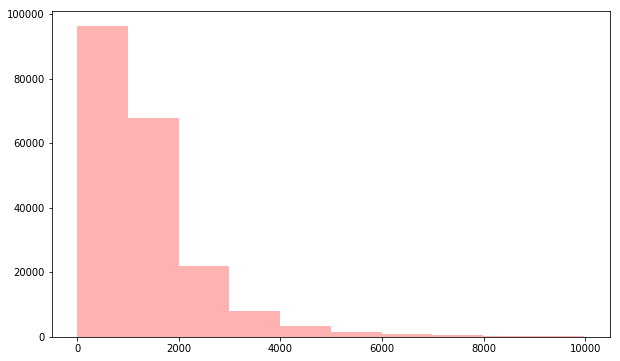

In [21]:
fig, ax = plt.subplots()

length = len_data[len_data < 10000].tolist()

n, bins, patches = ax.hist(length, color='r', alpha=.3)

fig.show()

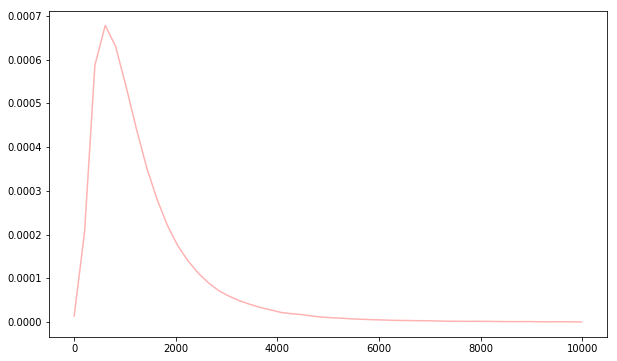

In [22]:
#выполним ядерную оценку плотности распределения длины символов с текстах
#df_r['text_len'] = df_r.text.apply(len)
my_density = gaussian_kde(length, bw_method = 0.1)

x = linspace(min(length), max(length))
plot(x, my_density(x),'r', alpha=.3)

Распределение кол-ва символов в тексте явно смещено в лево, интересно посмотреть какой вид будет иметь распределения если отбросить вылеты

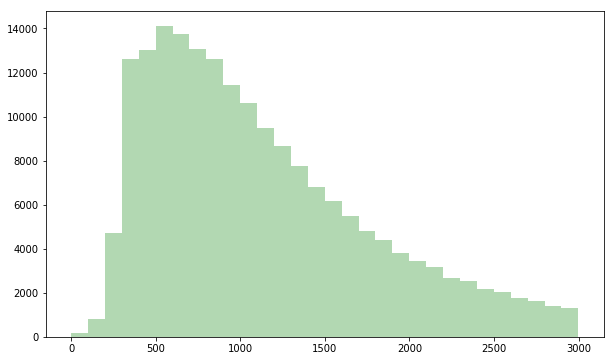

In [23]:
fig, ax = plt.subplots()

length_lt = len_data[len_data < 3000].tolist()

n, bins, patches = ax.hist(length_lt, color='g', bins=30, alpha=.3)

fig.show()

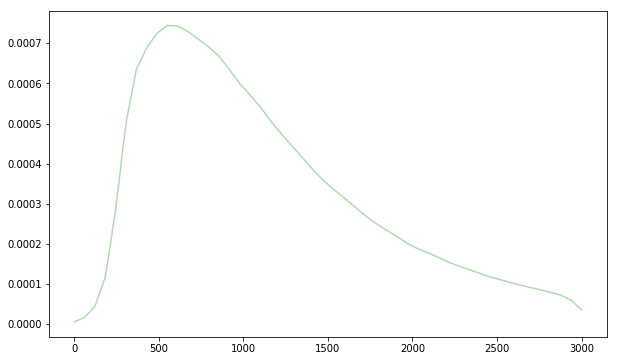

In [24]:
my_density = gaussian_kde(length_lt, bw_method = 0.1)

x = linspace(min(length_lt), max(length_lt))
plot(x, my_density(x),'g', alpha=.3)

#### 2.2 Гистограма кол-ва слов в текстах

In [25]:
words_l = []

for i in range(len(df_r['text'])):
    text = df.text.iloc[i].split()
    words_l.append(len(text))

df_r['words_l'] = words_l 
len_word = df_r['words_l']

In [26]:
df_r['words_l'].describe(percentiles=(0.1, 0.25, 0.75, 0.99))

count    201030.000000
mean        221.923360
std         191.083093
min           1.000000
10%          67.000000
25%         103.000000
50%         169.000000
75%         276.000000
99%         953.000000
max        5000.000000
Name: words_l, dtype: float64

In [25]:
#df_r[df_r['words_l'] == 5000].head()

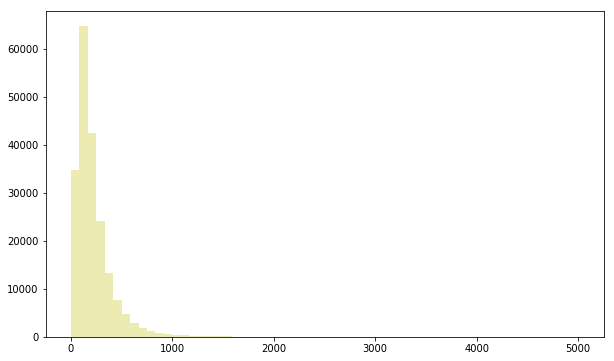

In [27]:
#посмотрим на картину вцелом, в нашей выборке есть очень серьезные выбросы (кто-то написал коментарий в 5000 слов)
fig, ax = plt.subplots()
n, bins, patches = ax.hist(len_word, color='y', bins=60, alpha=.3)
fig.show()

In [28]:
#отбросим все что больше 1000 слов
len_word_II = [x for x in df_r['words_l'] if x < 1000]

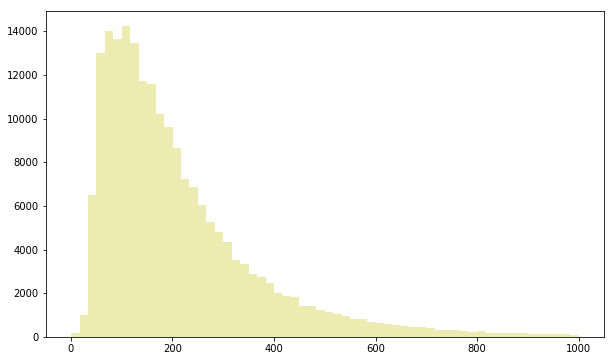

In [29]:
#посмотрим на распределение 99% наших данных
fig, ax = plt.subplots()
n, bins, patches = ax.hist(len_word_II, color='y', bins=60, alpha=.3)
fig.show()

### Вывод
Распределения частоты слов в текстах и символов в текстах смещены в лево, это вполне себе логично, обусловленно это структурой языка и словообразования

### 3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных

#### 3.1  10 самых частых слов 

In [31]:
from collections import Counter
from tqdm import tqdm_notebook as tqdm
cnt = Counter()
n_types_s = []
n_tokens_s = []
tokens_s = []
for index, row in tqdm(df_r.iterrows(), total = len(df_r)):
    tokens_s = row['text'].split()
    cnt.update(tokens_s)
    n_types_s.append(len(cnt))
    n_tokens_s.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)

HBox(children=(IntProgress(value=0, max=201030), HTML(value='')))


('в', 1623232)
('и', 1310026)
('не', 1044293)
('на', 861861)
('что', 774918)
('я', 701535)
('с', 571080)
('по', 456137)
('мне', 388914)
('банка', 344613)


#### 3.2  10 самых частых слов (без стоп-слов)

In [32]:
from nltk.corpus import stopwords

In [33]:
mystopwords = stopwords.words('russian')
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [34]:
df_r['text_SW'] = df_r['text'].apply(remove_stopwords)

In [35]:
cnt = Counter()
n_types_SW = []
n_tokens_SW = []
tokens_SW = []
for index, row in tqdm(df_r.iterrows(), total = len(df_r)):
    tokens_SW = row['text_SW'].split()
    cnt.update(tokens_SW)
    n_types_SW.append(len(cnt))
    n_tokens_SW.append(sum(cnt.values()))
for y in cnt.most_common(10):
    print(y)

HBox(children=(IntProgress(value=0, max=201030), HTML(value='')))


('банка', 344613)
('банк', 276836)
('это', 225916)
('деньги', 159460)
('карту', 128306)
('карты', 121705)
('т', 111924)
('кредит', 109081)
('день', 93177)
('банке', 92801)


#### 3.3  10 самых частых лемм

In [36]:
from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [37]:
df_r['lemma'] = df_r['text_SW'].apply(lemmatize)

In [39]:
lemmata = []
for index, row in df_r.iterrows():
    lemmata += row['lemma'].split()
cnt_l = Counter(lemmata)
for i in cnt_l.most_common(10):
    print(i)

('банк', 792690)
('карта', 404447)
('деньги', 218536)
('это', 209666)
('день', 208434)
('кредит', 207381)
('мой', 196307)
('который', 183077)
('клиент', 172908)
('отделение', 168773)


#### 3.4  10 самых частых существительных

In [38]:
import nltk
from nltk import word_tokenize, sent_tokenize
from pymorphy2 import MorphAnalyzer

In [ ]:
pm2 = MorphAnalyzer()

In [ ]:
words_ = []
for i in df_r['lemma']:
    words_.append(i)

In [ ]:
#O(n2) — квадратичная сложность 
nouns = []

for i in words_:
    w = nltk.word_tokenize(i) 
    for i in w:      
        if 'NOUN' in pm2.parse(i)[0].tag:
            nouns.append(i)

In [79]:
cnt_n = Counter(nouns)
for i in cnt_n.most_common(10):
    print(i)

('банк', 507084)
('карта', 259241)
('деньги', 138387)
('день', 134225)
('кредит', 128268)
('отделение', 117356)
('клиент', 112234)
('сотрудник', 112031)
('счет', 98256)
('сумма', 85239)


### Вывод
Немного капитанский вывод: распределение частоты слов без стоп-слов и существительных очень близкие, в принципе это логично

### 4. Постройте кривые Ципфа и Хипса

#### 4.1 Закон Ципфа

будем работать с текстами без стоп-слов

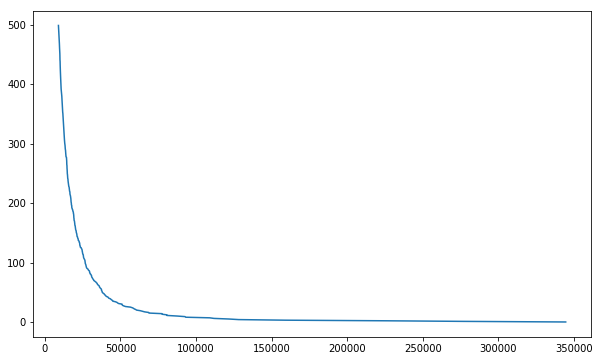

In [42]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:500], range(500))
plt.show()

#### 4.2 Закон Хипса

будем работать с текстами без стоп-слов

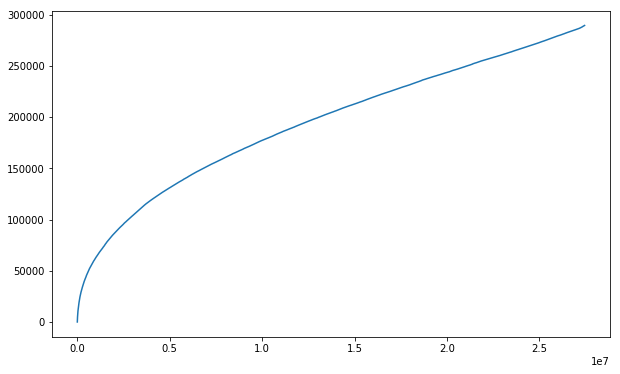

In [43]:
fig, ax = plt.subplots()
ax.plot(n_tokens_SW, n_types_SW)
plt.show()

### 5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

* какое слово встречается чаще, "сотрудник" или "клиент"?

In [175]:
for i in cnt_l.most_common():
    if 'сотрудник' in i:
        staff = i
    elif 'клиент' in i:
        guest = i
        
if staff[1] > guest[1]:
    #print(f'Слово "СОТРУДНИК" встречается чаще чем слово "КЛИЕНТ" ')
    print('Слово "СОТРУДНИК" встречается {s} раза, это чаще чем слово "КЛИЕНТ" {c} раза'.format(s = staff[1], c = guest[1]))
else:
    #print(f'Слово "КЛИЕН" встречается чаще чем слово "СОТРУДНИК"')
    print('Слово "КЛИЕН" встречается {c} раза, это чаще чем слово "СОТРУДНИК" {s} раза'.format(s = guest[1], c = staff[1]))
        

Слово "КЛИЕН" встречается 112031 раза, это чаще чем слово "СОТРУДНИК" 112234 раза


 * сколько раз встречается слова "мошенничество" и "доверие"?

In [178]:
for i in cnt_l.most_common():
    if 'мошенничество' in i:
        cheat = i
    elif 'доверие' in i:
        trust = i
        
if cheat[1] > trust[1]:
    #print(f'Слово "СОТРУДНИК" встречается чаще чем слово "КЛИЕНТ" ')
    print('Слово "МОШЕННИЧЕСТВО" встречается {ch} раза, это чаще чем слово "ДОВЕРИЕ" {tr} раза'.format(ch = cheat[1], tr = trust[1]))
else:
    #print(f'Слово "КЛИЕН" встречается чаще чем слово "СОТРУДНИК"')
    print('Слово "ДОВЕРИЕ" встречается {tr} раза, это чаще чем слово "МОШЕННИЧЕСТВО" {ch} раза'.format(tr = trust[1], ch = cheat[1]))

Слово "МОШЕННИЧЕСТВО" встречается 1842 раза, это чаще чем слово "ДОВЕРИЕ" 1725 раза


### 6.  В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

- выберем данные с положительными оценками `df_pstv` и негативными `df_ngtv`

In [77]:
df_pstv.head()

,author,bank_name,city,rating_grade,text,title,city_n,words_l,text_SW,lemma
0,e.novikova,ВТБ 24,г. Воронеж,5.0,здравствуйте хотелось бы выразить благодарност...,Ипотека на 5+,Воронеж,156,здравствуйте хотелось выразить благодарность б...,здравствовать хотеться выражать благодарность ...
9,кристина1987,ВТБ 24,г. Москва,5.0,хочу поблагодарить надежду из отдела по ипотеч...,Большая блаодарность!,Москва,83,хочу поблагодарить надежду отдела ипотечному к...,хотеть поблагодарить надежда отдел ипотечный к...
31,Мёрфи,ВТБ 24,г. Екатеринбург,5.0,выплату из асв по транспортному банку пошел по...,Знакомство с банком,Екатеринбург,76,выплату асв транспортному банку пошел получать...,выплата асв транспортный банк пойти получать в...
40,vs1l,Ланта-Банк,г. Куйбышев,5.0,в куйбышевском филиале в головном офисе просто...,Просто превосходно!,Куйбышев,95,куйбышевском филиале головном офисе просто пре...,куйбышевский филиал головной офис просто прекр...
84,sergei.sadomskov,Сбербанк России,г. Заокский,5.0,хочу выразить огромную благодарность сотрудник...,Благодарность сотруднику,Заокский,113,хочу выразить огромную благодарность сотрудник...,хотеть выражать огромный благодарность сотрудн...


In [68]:
df_pstv = df_r[df_r['rating_grade'] == 5]
df_ngtv = df_r[df_r['rating_grade'] == 1]

- посмотрим на их соотношения

In [75]:
df_pstv.shape[0], df_ngtv.shape[0] , df_pstv.shape[0]/(df_pstv.shape[0] + df_ngtv.shape[0]), \
                                                                df_ngtv.shape[0]/(df_pstv.shape[0] + df_ngtv.shape[0])

(26715, 72307, 0.269788531841409, 0.7302114681585911)

вывод: негативных комментариев более чем в два раза больше, либо банки плохо работают, либо `homo` подсознательно тяготеет к негативным комментариям

In [83]:
cnt_p = Counter()
n_types_p = []
n_tokens_p = []
tokens_p = []
for index, row in tqdm(df_pstv.iterrows(), total = len(df_pstv)):
    tokens_p = row['lemma'].split()
    cnt_p.update(tokens_p)
    n_types_p.append(len(cnt_p))
    n_tokens_p.append(sum(cnt_p.values()))
for i in cnt_p.most_common(10):
    print(i)

HBox(children=(IntProgress(value=0, max=26715), HTML(value='')))


('банк', 92283)
('карта', 34356)
('очень', 26055)
('кредит', 22240)
('клиент', 21275)
('это', 20255)
('сотрудник', 19911)
('отделение', 18728)
('день', 18701)
('который', 17547)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking = []
dense = tfidf_matrix.todense()

text = dense[topic_id].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking.append(phrase)

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])



## Версия II (работать будем c json)

In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

In [2]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:14, 1498.43it/s]


## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [5]:
responses[0]

{'author': 'uhnov1',
 'bank_license': 'лицензия № 2562',
 'bank_name': 'Бинбанк',
 'city': 'г. Москва',
 'datetime': '2015-06-08 12:50:54',
 'num_comments': 0,
 'rating_grade': None,
 'rating_not_checked': False,
 'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не 

In [42]:
count_C = [k['city'] for k in responses if k.get('city') ]
len(count_C)

138325

In [24]:
count_R = [r['bank_name'] for r in responses if r.get('bank_name') ]
len(count_R)

153499

In [34]:
from collections import Counter
counts = Counter(count_R)
print(counts)

Counter({'Сбербанк России': 26327, 'Альфа-Банк': 10224, 'ВТБ 24': 8185, 'Русский Стандарт': 7943, 'Хоум Кредит Банк': 7549, 'Тинькофф Банк': 5387, 'Национальный Банк «Траст»': 4607, 'Ренессанс Кредит': 3849, 'Связной Банк': 3775, 'ОТП Банк': 3237, 'Восточный Экспресс Банк': 3138, 'Райффайзенбанк': 3057, 'Московский Кредитный Банк': 2944, 'Ситибанк': 2848, 'Авангард': 2733, 'Промсвязьбанк': 2586, 'ЮниКредит Банк': 2488, 'Банк Москвы': 2456, 'Ханты-Мансийский банк Открытие': 2158, 'МТС Банк': 1870, 'Киви Банк': 1741, 'Кредит Европа Банк': 1683, 'Росбанк': 1658, 'Бинбанк': 1646, 'БИНБАНК кредитные карты': 1464, 'Сетелем Банк': 1351, 'Московский Областной Банк': 1277, 'Юниаструм Банк': 1111, 'Современный Коммерческий Банк (бывш. ДжиИ Мани Банк)': 993, 'Уралсиб': 989, 'АйМаниБанк': 925, 'Совкомбанк': 919, 'Абсолют Банк': 782, 'МДМ Банк': 776, 'Русфинанс Банк': 723, 'Русславбанк': 715, '2Т Банк': 655, 'СБ Банк (Судостроительный банк)': 555, 'ФК Открытие (бывш. НОМОС-Банк)': 549, 'Россельхозб

In [45]:
counts_ = Counter(count_C)
print(counts_)

Counter({'г. Москва': 55354, 'г. Санкт-Петербург': 14342, 'г. Екатеринбург': 2337, 'г. Новосибирск': 2300, 'г. Нижний Новгород': 1976, 'г. Ростов-на-Дону': 1891, 'г. Самара': 1731, 'г. Челябинск': 1507, 'г. Казань': 1440, 'г. Краснодар': 1262, 'г. Уфа': 1246, 'г. Красноярск': 1236, 'г. москва': 1217, 'г. Воронеж': 1210, 'г. Пермь': 1163, 'г. Волгоград': 1014, 'г. Омск': 989, 'г. Саратов': 933, 'г. Иркутск': 749, 'г. Калининград': 746, 'г. Ставрополь': 696, 'г. Хабаровск': 681, 'г. Тюмень': 656, 'г. Владивосток': 637, 'г. Ярославль': 609, 'г. Барнаул': 609, 'г. Тула': 586, 'г. Томск': 569, 'г. Рязань': 548, 'г. Ульяновск': 500, 'г. Тольятти': 473, 'г. Липецк': 461, 'г. Иваново': 458, 'г. Ижевск': 454, 'г. Тверь': 447, 'г. Мурманск': 434, 'г. Пенза': 433, 'г. Оренбург': 431, 'г. Чебоксары': 392, 'г. Кемерово': 390, 'г. Белгород': 387, 'г. Магнитогорск': 379, 'г. Сочи': 367, 'г. Владимир': 363, 'г. Курск': 360, 'г. Астрахань': 330, 'г. Архангельск': 328, 'г. Калуга': 327, 'г. Новокузнецк'

In [46]:
from collections import Counter
from tqdm import tqdm_notebook as tqdm
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['title'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)

HBox(children=(IntProgress(value=0, max=201030), HTML(value='')))


('в', 22372)
('не', 17375)
('и', 15516)
('на', 14357)
('с', 13532)
('по', 10508)
('Не', 8829)
('банка', 8769)
('деньги', 7609)
('карты', 7444)


In [ ]:

index = 0
while index < len(responses):
    for key in responses[index]:
        print(responses[index][key])
    index += 1

NameError: name 'inpt' is not defined